ЗАДАНИЕ КУРСОВОГО ПРОЕКТА.

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

# Подключаем библиотеки и скрипты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

# Датасеты

In [4]:
Train_Dataset='Downloads/train.csv'
Test_Dataset='Downloads/test.csv'
Predictions='DDemchenko_predictions.csv'

# Загрузка данных

In [5]:
train_df = pd.read_csv(Train_Dataset)
test_df = pd.read_csv(Test_Dataset)

# Обзор обучающего датасета

In [6]:
print(train_df.shape)

(10000, 20)


In [7]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


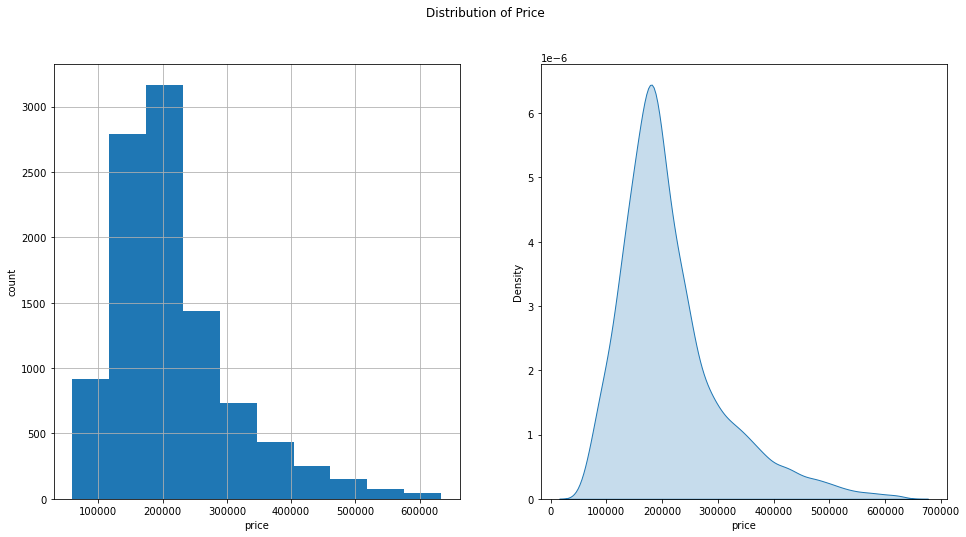

In [9]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Distribution of Price')
plt.show()

# Подготавливаем обучающий датасет

Исключаем признак "Healthcare_1", т.к. по нему почти 50% пропусков

In [10]:
train_df = train_df.drop('Healthcare_1', axis=1)

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [11]:
print(train_df['Ecology_2'].value_counts())
print(train_df['Ecology_3'].value_counts())
print(train_df['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [12]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Работаем с выбросами признака "Rooms"

In [13]:
rooms_med = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_med

Работаем с выбросами признаков LifeSquare и KitchenSquare

In [14]:
lifesq_med = train_df['LifeSquare'].median()
kitchsq_med = train_df['KitchenSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] > 400, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

Работаем с выбросами признака "Square"

In [15]:
square_med = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_med
train_df.loc[train_df['Square'] > 400, 'Square'] = square_med

Работаем с выбросами признака "HouseYear"

In [16]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Работаем с выбросами признаков "Floor" и "HouseFloor"

In [17]:
hfloor_med = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

In [18]:
ind = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind, 'Floor'] = train_df.loc[ind, 'HouseFloor']

Вычисляем "m_2_Price" - стоимость квадратного метра общей площади

In [19]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']

На его основе создаем новые признаки m_2_MedPriceByDistrict 
- медианная стоимость квадратного метра в зависимости от района 
и m_2_MedPriceByHouseYear - медианная стоимость квадратного метра в зависимости от возраста дома

In [20]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

Добавляем новые признаки к датасету

In [21]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,3854.958571,4358.274853,4473.255408
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,4567.491245,4437.304072,4317.685445
2,4765,53,2.0,44.947953,29.197612,6.0,8.0,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,4915.149522,4845.919064,4429.204254
3,5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,3291.591637,2949.975415,2901.326376
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,3788.892642,3992.031265,4367.263383


In [22]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,56.228457,35.980607,7.490600,7.918200,12.95910,1984.872400,0.118858,...,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3891.739716,3927.295723,3780.144330
std,4859.01902,43.587592,0.812096,19.058793,15.378518,3.290409,5.186386,6.44346,18.416347,0.119025,...,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1251.728243,997.479341,762.735269
min,0.00000,0.000000,1.000000,16.117154,10.523868,5.000000,1.000000,1.00000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2273.498737,2764.147132
25%,4169.50000,20.000000,1.000000,41.800063,27.654813,6.000000,4.000000,9.00000,1974.000000,0.017647,...,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2916.973642,2938.048239,2901.326376
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.00000,1977.000000,0.075424,...,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3907.999942,4134.353749,4285.794408
75%,12592.50000,75.000000,2.000000,65.889736,41.415441,9.000000,11.000000,17.00000,2001.000000,0.195781,...,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4690.526670,4562.026777,4409.376396
max,16798.00000,209.000000,6.000000,275.645284,263.542020,78.000000,42.000000,117.00000,2020.000000,0.521867,...,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11854.652892,8700.768533,7823.822055


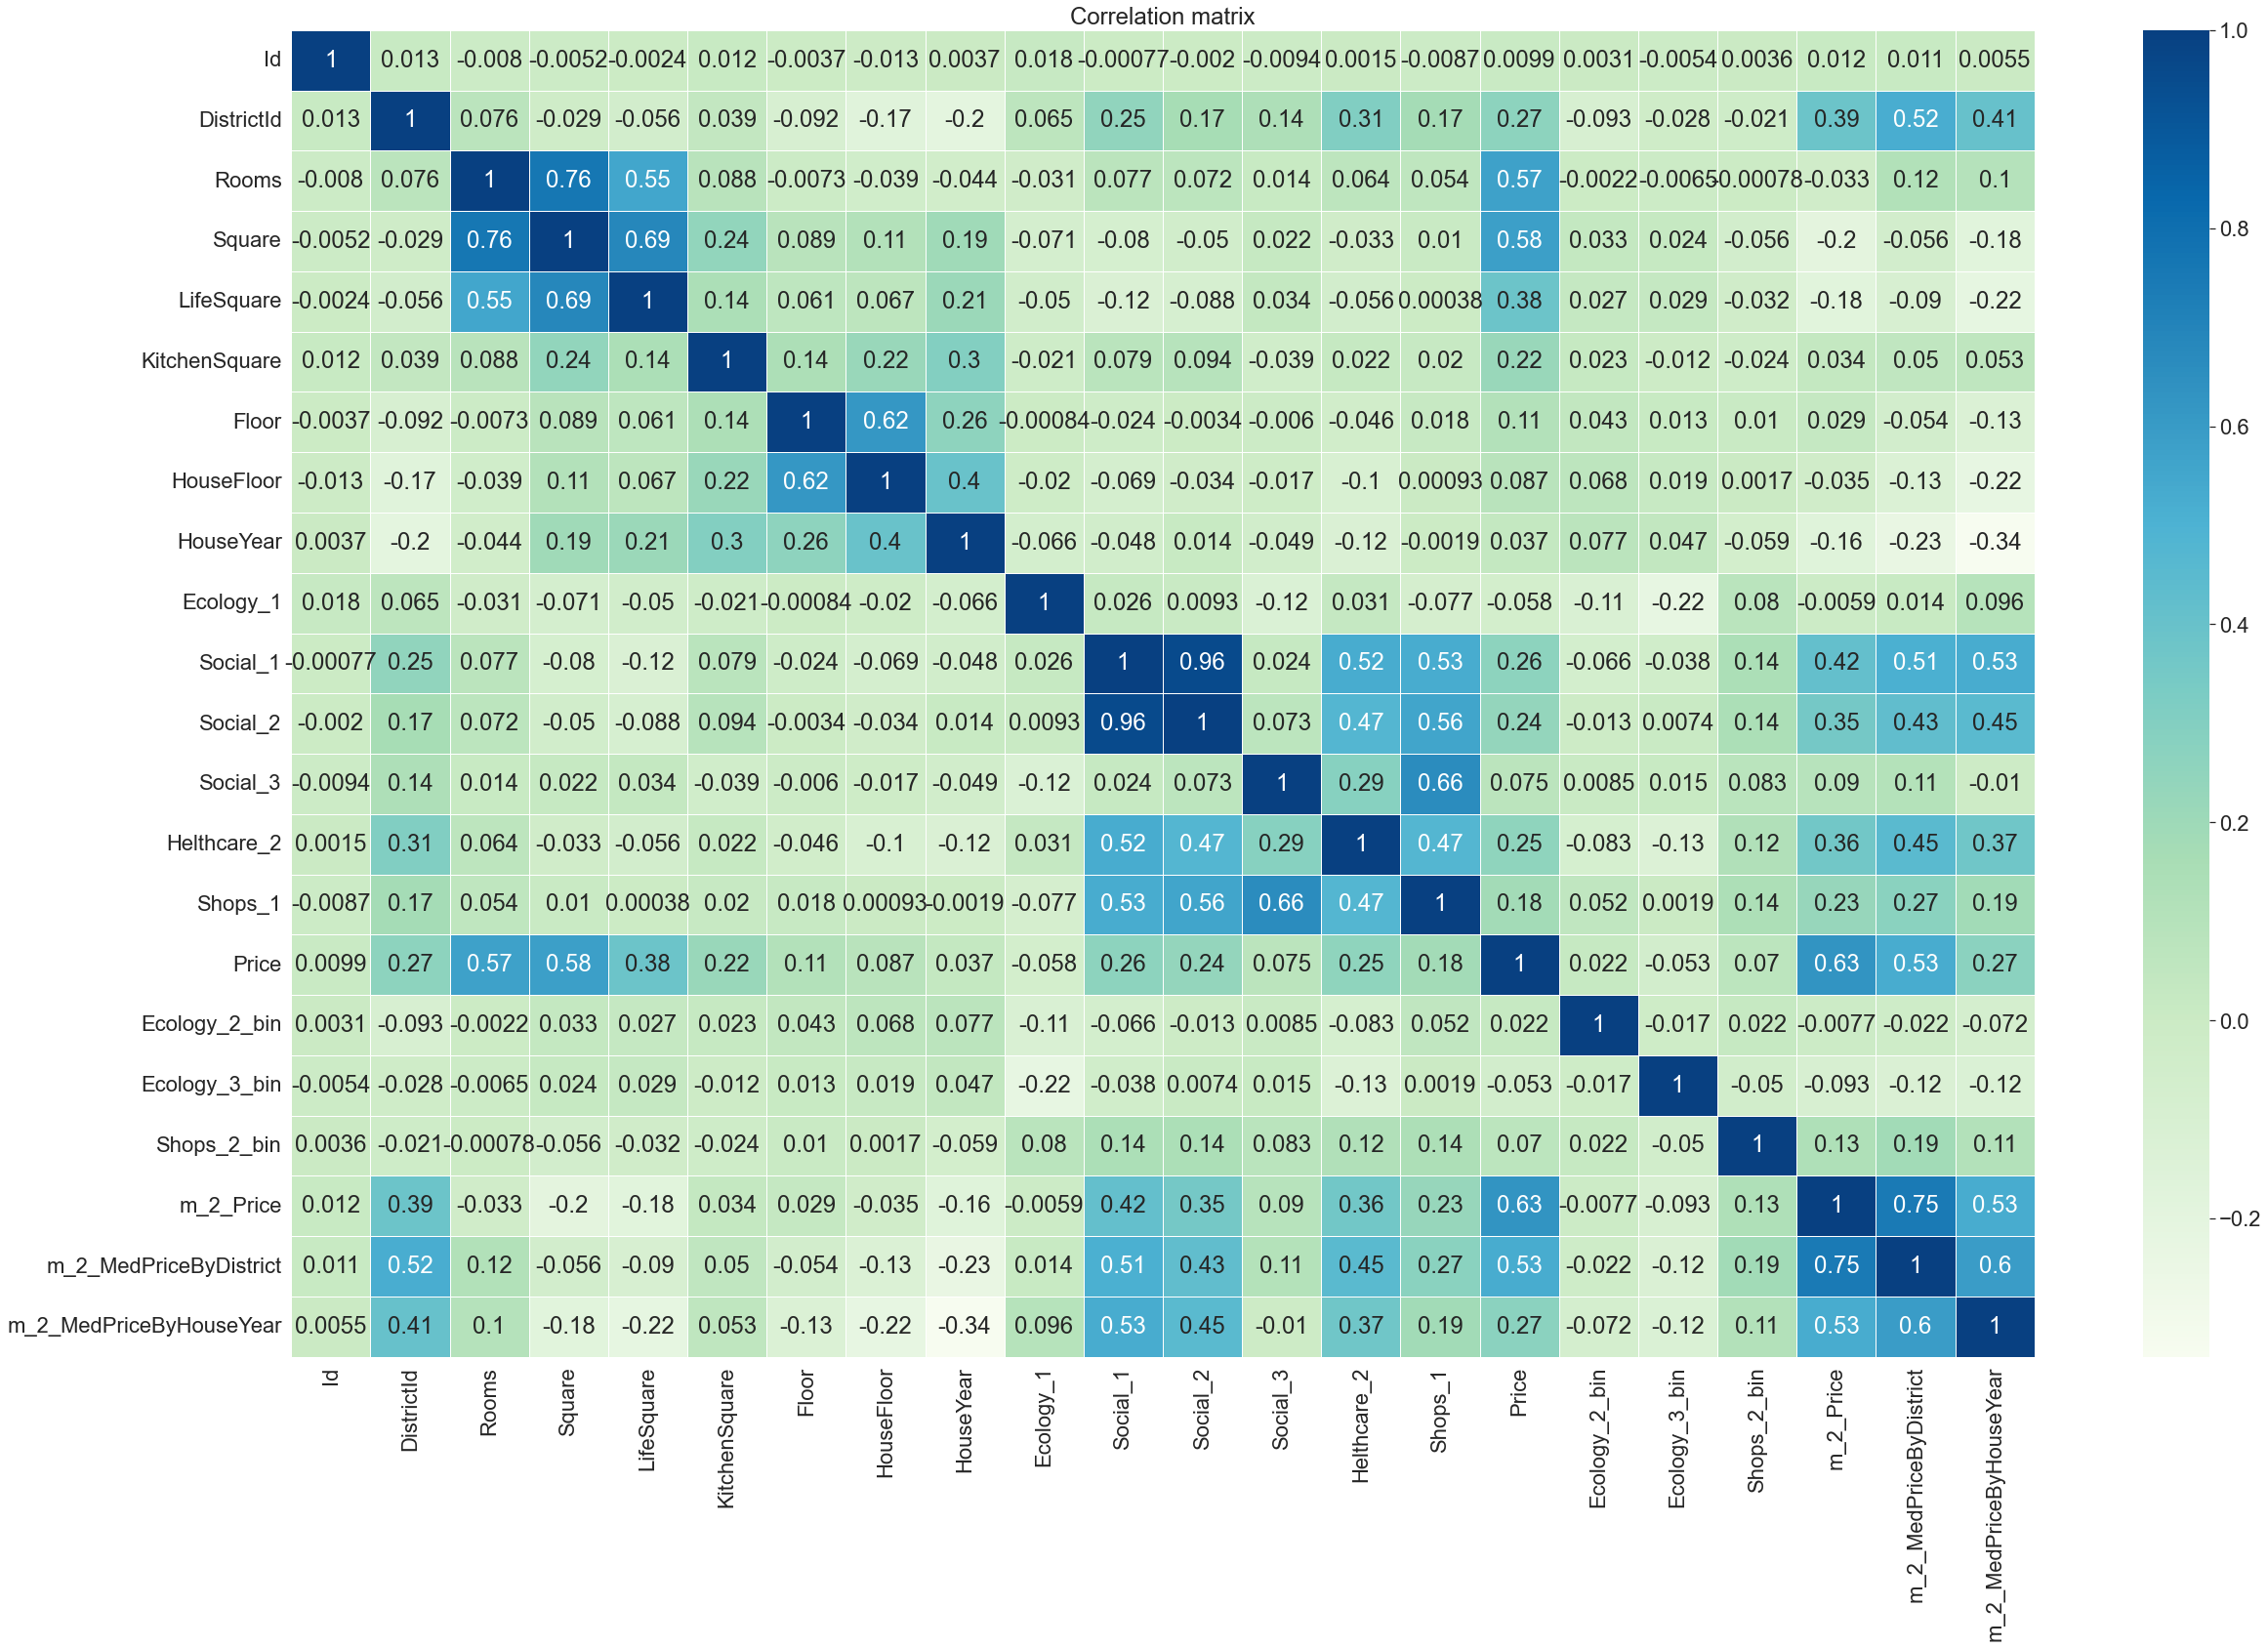

In [23]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Отбираем признаки для модели

In [24]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [25]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,4358.274853,4473.255408,0.089040,33,5,0,11,1,1,1,184966.930730
1,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,4437.304072,4317.685445,0.000070,46,1,1,16,1,1,1,300009.450063
2,2.0,44.947953,29.197612,6.0,8.0,12.0,1968,4845.919064,4429.204254,0.049637,34,0,1,3,1,1,1,220925.908524
3,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,2949.975415,2901.326376,0.437885,23,3,0,5,1,1,1,175616.227217
4,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,3992.031265,4367.263383,0.012339,35,1,2,4,1,1,1,150226.531644


Масштабируем признаки

In [26]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [27]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,0.136936,-0.432730,-0.425150,-0.453036,-0.177049,-0.614468,-0.861908,0.432090,0.908763,-0.250529,0.474169,-0.127533,-0.883480,1.408356,0.09897,0.16816,0.299864,184966.930730
1,1.368379,0.496131,0.264599,0.154821,-0.177049,-0.614468,-0.373187,0.511323,0.704790,-0.998053,1.215681,-0.295384,-0.213923,2.448700,0.09897,0.16816,0.299864,300009.450063
2,0.136936,-0.591909,-0.441092,-0.453036,0.015773,-0.148856,-0.916210,0.920991,0.851006,-0.581588,0.531208,-0.337347,-0.213923,-0.256195,0.09897,0.16816,0.299864,220925.908524
3,0.136936,-0.150882,1.089295,0.458750,0.015773,0.627163,-0.427489,-0.979839,-1.152250,2.680470,-0.096225,-0.211458,-0.883480,0.159943,0.09897,0.16816,0.299864,175616.227217
4,-1.094506,-0.869945,-0.793643,-0.149107,0.594239,-0.148856,-0.481792,0.064902,0.769793,-0.894969,0.588247,-0.295384,0.455633,-0.048126,0.09897,0.16816,0.299864,150226.531644


Разбиваем на обучающую и валидационную выборку

In [28]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

Строим и обучаем модель

In [29]:
model = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)

In [30]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)

R2:	0.933


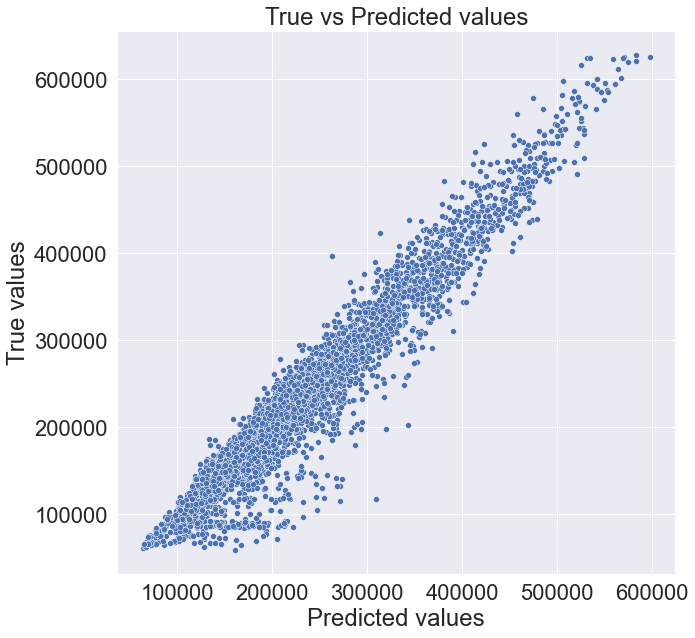

In [31]:
y_train_preds = model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

Проверяем на валидационной выборке

R2:	0.743


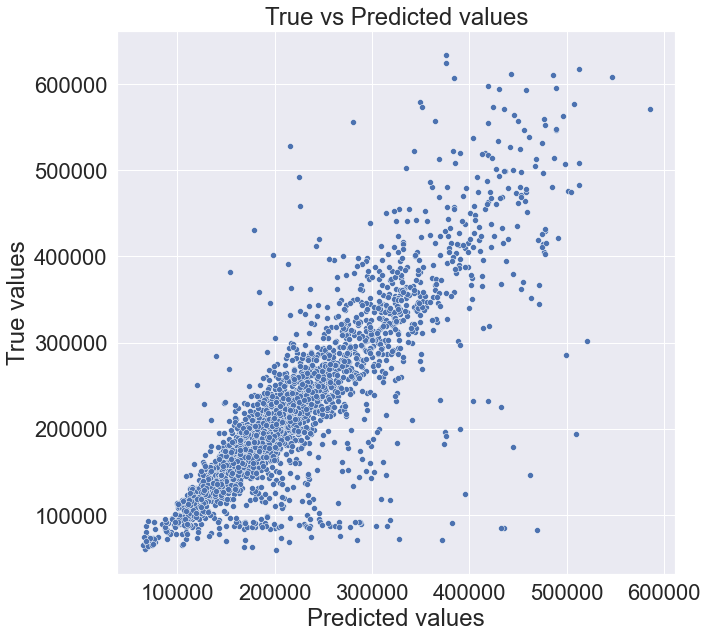

In [32]:
y_valid_preds = model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

Важность признаков

In [33]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.439970
7,m_2_MedPriceByDistrict,0.354208
8,m_2_MedPriceByHouseYear,0.031053
0,Rooms,0.027099
10,Social_1,0.021941
2,LifeSquare,0.019304
6,HouseYear,0.017761
9,Ecology_1,0.016969
4,Floor,0.016098
3,KitchenSquare,0.014125


# Обзор тестового датасета

In [34]:
print(test_df.shape)

(5000, 19)


In [35]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [36]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


# Подготавливаем тестовый датасет

Исключаем признак "Healthcare_1", т.к. по нему почти 50% пропусков

In [37]:
test_df = test_df.drop('Healthcare_1', axis=1)

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [38]:
print(test_df['Ecology_2'].value_counts())
print(test_df['Ecology_3'].value_counts())
print(test_df['Shops_2'].value_counts())

B    4952
A      48
Name: Ecology_2, dtype: int64
B    4851
A     149
Name: Ecology_3, dtype: int64
B    4588
A     412
Name: Shops_2, dtype: int64


In [39]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

Работаем с выбросами признака "Rooms"

In [40]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = rooms_med

Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"

In [41]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

Работаем с выбросами признака "Square"

In [42]:
test_df.loc[test_df['Square'] < 16, 'Square'] = square_med
test_df.loc[test_df['Square'] > 400, 'Square'] = square_med

Работаем с выбросами признаков "Floor" и "HouseFloor"

In [43]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

In [44]:
ind = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind, 'Floor'] = test_df.loc[ind, 'HouseFloor']

Добавляем новые признаки к датасету

In [45]:
test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

Заполняем возможные пропуски

In [46]:
test_df.loc[test_df['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] =\
                    m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()

In [47]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] < 1950), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] < 1950,
                                                  'm_2_MedPriceByHouseYear'].median()

In [48]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1990), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] >= 1990,
                                                  'm_2_MedPriceByHouseYear'].median()

In [49]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1950) &\
                    (test_df['HouseYear'] < 1990), 'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[(m_2_MedPriceByHouseYear['HouseYear'] >= 1950) & \
                                                  (m_2_MedPriceByHouseYear['HouseYear'] < 1990),
                                                  'm_2_MedPriceByHouseYear'].median()

In [50]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.90780,56.543749,36.047463,7.425800,8.054000,12.941600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.990400,0.970200,0.917600,3946.750805,3790.421605
std,4832.674037,44.179466,0.81008,18.955344,14.706864,3.038674,5.337076,6.466881,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.097518,0.170052,0.275001,985.494228,761.818482
min,1.000000,0.000000,1.00000,16.319015,10.692499,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2273.498737,2793.739365
25%,4221.750000,21.000000,1.00000,41.951045,27.990919,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,2949.975415,2901.326376
50%,8320.500000,37.000000,2.00000,52.921340,32.781260,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,1.000000,1.000000,1.000000,4158.187979,4285.794408
75%,12598.250000,77.000000,2.00000,66.285129,41.760597,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,1.000000,1.000000,1.000000,4571.660177,4409.376396
max,16795.000000,212.000000,6.00000,223.453689,169.901701,65.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,1.000000,8700.768533,7823.822055


# Масштабируем признаки

In [51]:
stand_features = scaler.fit_transform(test_df[feature_names])

In [52]:
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

# Предсказываем цены для тестового датасета# 

In [53]:
X_test = test_df[feature_names]

In [54]:
y_test_preds = model.predict(X_test)

# Сохраняем результаты

In [55]:
test_df['Price'] = y_test_preds

In [57]:
test_df.to_csv(Predictions, columns=['Id', 'Price'], index=False, encoding='utf-8')